In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.registration import optical_flow_ilk, optical_flow_tvl1
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from tqdm.notebook import tqdm
import os
from scipy import stats
from numpy.lib.stride_tricks import sliding_window_view
import math
from glob import glob
import slideio


In [26]:
FIELD_SIZE = 512
RECORD_DURATION = 100
RECORD_FPS = 15

In [27]:
# dpcca
base = 1.1
smin = 8
L = RECORD_DURATION
smax = L/2
S = []
for degree in range(int(math.log2(smin)/math.log2(base)), int(math.log2(smax)/math.log2(base))):
    new = int(base**degree)
    if not new in S:
        S.append(new)
print(S)

[7, 8, 9, 10, 11, 13, 14, 15, 17, 19, 21, 23, 25, 28, 30, 34, 37, 41, 45]


In [28]:
def video_based_frame_generator(video_path, start_frame=0, step=1, blur_sigma=None, frame_count=np.iinfo(int).max):
    cap = cv2.VideoCapture(video_path) 
    if not cap.isOpened():
        print("Cannot open camera")
        return
    
    count = start_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    while True:
        ret, frame = cap.read()
        if not ret or count>= frame_count:
            print("Can't receive frame (stream end?). Exiting ...")
            cap.release()
            break
        grey_np = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #hsv_frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        #grey_np = hsv_frame_np[...,1]
        #grey_np = cv2.resize(grey_np, (FIELD_SIZE, FIELD_SIZE), interpolation= cv2.INTER_LINEAR)
        if blur_sigma is not None:
            grey_np = gaussian_filter(grey_np, sigma=blur_sigma)
        count += step 
            
        cap.set(cv2.CAP_PROP_POS_FRAMES, count)
        yield grey_np
    cap.release()
    
def zvi_based_frame_generator(video_path, start_frame=0, step=1, blur_sigma=None, frame_count=np.iinfo(int).max):
    slide = slideio.open_slide(video_path,"ZVI")
    scene = slide.get_scene(0)
    for frame_i in range(0, frame_count):
        i = frame_i % scene.num_t_frames
        yield scene.read_block(rect=(0,0,0,0), size=(0,0), channel_indices=[0], slices=(0,1), frames=(i,i+1))
    
def frame_generator(video_path:str, start_frame=0, step=1, blur_sigma=None, frame_count=np.iinfo(int).max):
    if video_path.endswith("zvi"):
        return zvi_based_frame_generator(video_path, start_frame, step, blur_sigma, frame_count)
    else:
        return video_based_frame_generator(video_path, start_frame, step, blur_sigma, frame_count)

In [29]:
from utils.optical_flow import compute_optical_low 
from utils.stats import plot_entire_stat_tresh, analyze_hs

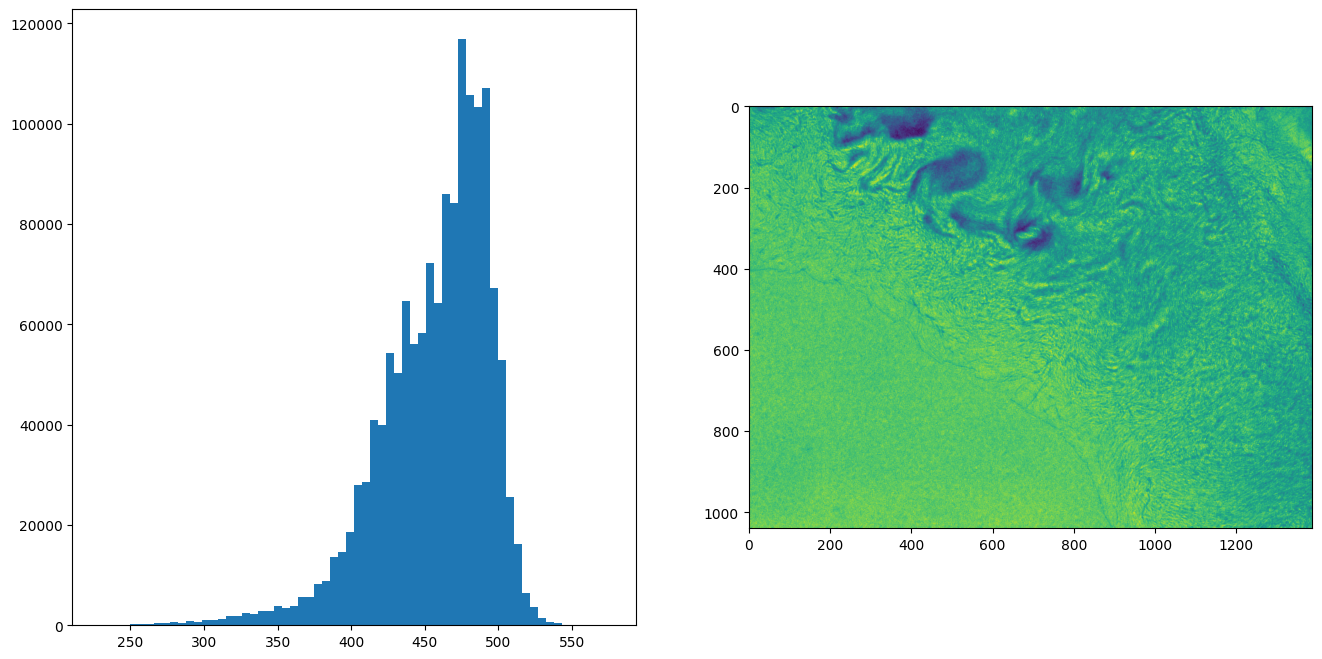

In [30]:
frame_np = frame_generator("../data/bacterial_video/pDG148-LA.zvi", blur_sigma=1, frame_count=RECORD_DURATION).__next__()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1.hist(frame_np.flatten(), bins=64)
ax2.imshow(frame_np)
plt.show()

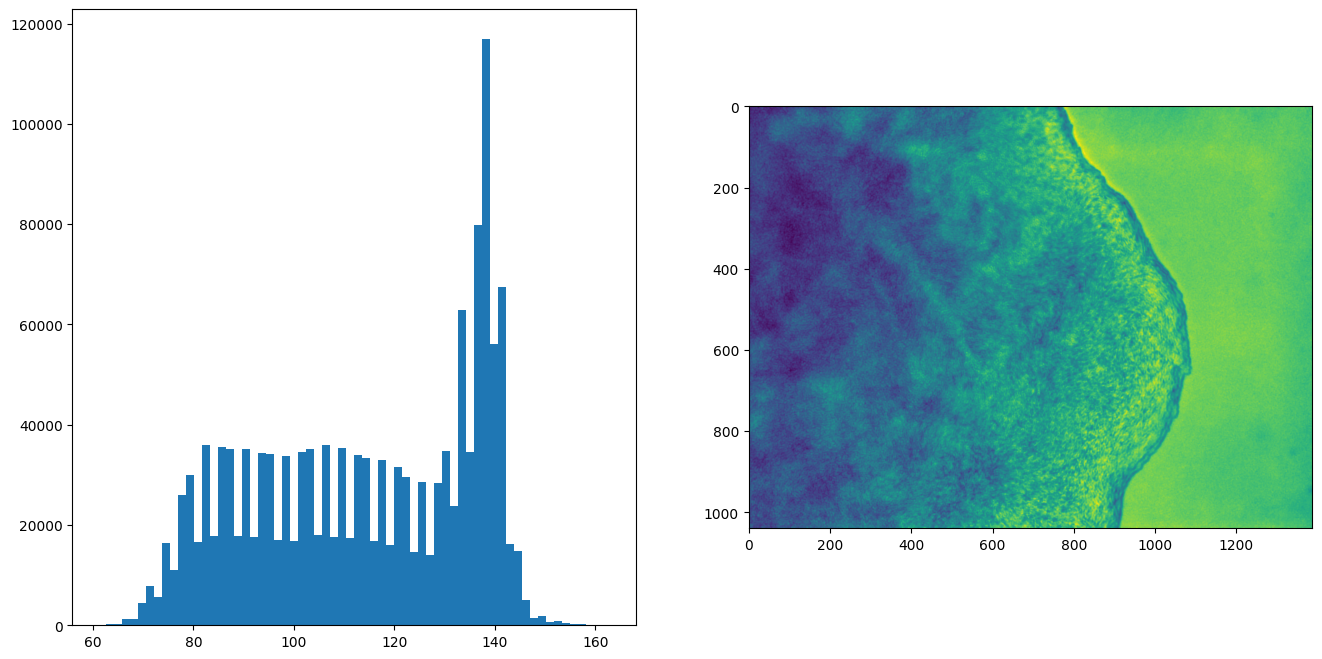

In [31]:
frame_np = video_based_frame_generator("../data/bacterial_video/B.S.380-LA (2.2)(+)_t001.AVI", blur_sigma=1, frame_count=RECORD_DURATION).__next__()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1.hist(frame_np.flatten(), bins=64)
ax2.imshow(frame_np)
plt.show()

In [32]:
def compute_optical_low(generator, radius=None, gen_length=None):
    vs, us = [], []
    image0 = None
    for frame_np in tqdm(generator, total=gen_length):
        clear_output(wait=True)
        #Build masked Image
        frame_blur = frame_np#cv2.blur(frame_np,(5,5))
        if image0 is None:
            image0 = frame_blur
        else:
            # --- Compute the optical flow
            image1 = frame_blur
            #v, u = optical_flow_ilk(image0, image1, radius=25)
            v, u = optical_flow_tvl1(image0, image1)
            image0 = image1.copy()
            vs.append(v)
            us.append(u)
    return np.array(vs), np.array(us)

In [33]:
def get_vid_opt_flow(video_path, cache_path, start_frame=0, step=1):
    if not os.path.exists(cache_path):
        vs_np, us_np = compute_optical_low(frame_generator(video_path, blur_sigma=1, start_frame=start_frame, step=step, frame_count=RECORD_DURATION)) # 3 sec for performance
        np.savez(cache_path, vs=vs_np, us=us_np)
    else:
        with np.load(cache_path) as npzfile:
            vs_np = npzfile["vs"]
            us_np = npzfile["us"]
    return vs_np, us_np

In [34]:
def bacterial_ds_generator(video_folder, cache_folder):
    videos = glob(os.path.join(video_folder, f"*.avi"))
    for vid in videos:
        vid_name = os.path.split(vid)[1][:-4]
        cache_path = os.path.join(cache_folder, vid_name+".npz")
        yield vid, cache_path
        
for v, c in bacterial_ds_generator("../data/bacterial_video/", "../data/bacterial_video/"):
    print(v, c)

In [35]:
H_fish = []
cut_point = 0
temp = None
THRESH = 0.5
for v, c in bacterial_ds_generator("../data/bacterial_video/", "../data/bacterial_video/"):
    print(v, c)
    vs_np, us_np = get_vid_opt_flow(v, c)
    #vs_np, us_np = vs_np[..., :694], us_np[..., :694]
    vector_field = vs_np + 1j * us_np
    plot_entire_stat_tresh((vs_np.shape[1],vs_np.shape[2]), vs_np, us_np, thresh=THRESH)
    
    vector_field = vs_np + 1j * us_np
    compl_vars_ = []
    for w_size in tqdm(S):
        window = sliding_window_view(vector_field, w_size, axis=0)[::w_size//4, ...]
        # magn = np.abs(window)
        # H = np.std(np.sum(window, where=magn>np.quantile(magn, THRESH), axis=-1))
        H = np.std(np.sum(window, axis=-1))
        compl_vars_.append(H)
    H_fish.append(np.array(compl_vars_))
    
    cross, slope_l, slope_h = analyze_hs(compl_vars_, np.array(S), title=f"H(S): {v}")

In [13]:
import numpy as np
import cv2
size = 720*16//9, 720
duration = 2
fps = 25
out = cv2.VideoWriter('./bacterial_video/optical_flow_B.S.380-LA (2.2)(+)_t001.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), False)
for _ in range(fps * duration):
    data = np.random.randint(0, 256, size, dtype='uint8')
    out.write(data)
out.release()

In [23]:
# imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Use Agg backend for canvas
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
vs_np, us_np = get_vid_opt_flow("../data/bacterial_video/B.S.380-LA (2.2)(+)_t001.AVI", "../data/bacterial_video/B.S.380-LA (2.2)(+)_t001.npz")


In [24]:
vs_np.shape

(0,)

In [18]:
nl, nc = vs_np.shape[1:]
nvec = 25  # Number of vectors to be displayed along each image dimension
step = max(nl//nvec, nc//nvec)


low_perc = 0.1
hig_perc = 0.9
v_05 = np.quantile(vs_np, low_perc)# y direction    
v_95 = np.quantile(vs_np, hig_perc)# y direction    
u_05 = np.quantile(us_np, low_perc)# x direction
u_95 = np.quantile(us_np, hig_perc)# x direction
# --- Compute flow magnitude
magn_05 = np.sqrt(v_05 ** 2 + u_05 ** 2)
magn_95 = np.sqrt(v_95 ** 2 + u_95 ** 2)

ValueError: not enough values to unpack (expected 2, got 0)

0it [00:00, ?it/s]

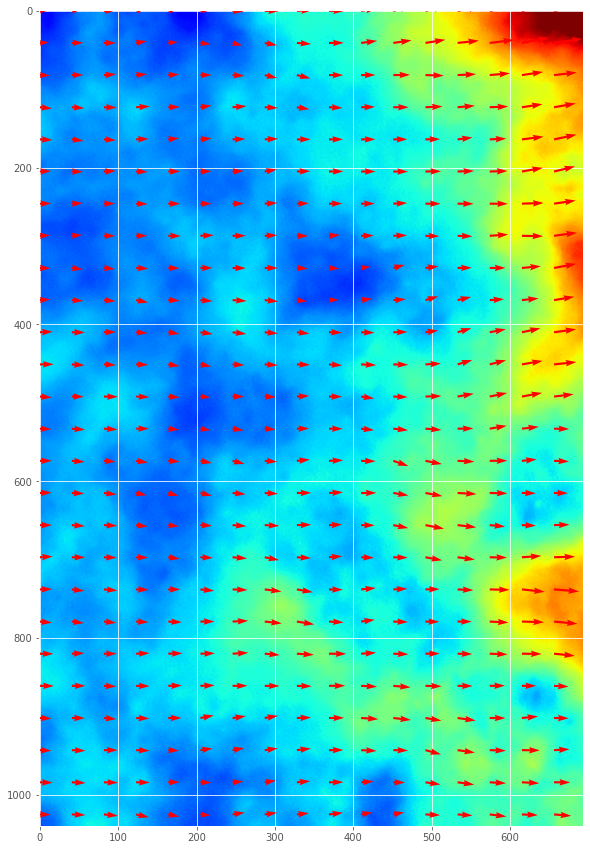

In [29]:
from matplotlib.animation import FFMpegWriter
plt.style.use("ggplot")
fig = plt.figure(figsize=(10,15))
plt.axis('off')
writervideo = FFMpegWriter(fps=10) 
with writervideo.saving(fig, "./bacterial_video/half_optical_flow_B.S.380-LA (2.2)(+)_t001.mp4", 100):
    for v_np, u_np in tqdm(zip(vs_np, us_np)):
        fig.clf()
        # --- Display
        # --- Quiver plot arguments
        y, x = np.mgrid[:nl:step, :nc:step]
        u_ = u_np[::step, ::step]
        v_ = v_np[::step, ::step]

        norm = np.sqrt(v_np ** 2 + u_np ** 2)
        fig.gca().imshow(norm, vmin=magn_05, vmax=magn_95, cmap="jet")
        fig.gca().quiver(x, y, u_, v_, color='r', units='dots',
                   angles='xy', scale_units='xy', lw=3)
        writervideo.grab_frame()